# Add title here.

## Analysis setup

We begin by loading the Distributions and LowRankApprox Julia packages, as well as some function definitions used in the code chunks below.

In [6]:
using RCall
using LowRankApprox
using PyPlot
using Distributions

In [29]:
include("../code/julia/QPsubprob.jl");
include("../code/julia/datasim.jl");
include("../code/julia/likelihood.jl");

In [3]:
L = Array{Float64,2}(CSV.read("../data/sample100000x100.txt", nullable = false, header = false, delim = ' '));

In [6]:
QPsubprob(L, method = "mosek2")

Dict{String,Any} with 7 entries:
  "q_nnz"       => [4.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0,…
  "eachQPtime"  => [0.0076135, 0.00864415, 0.00725804, 0.00832327, 0.00718117, …
  "y_nnz"       => [4.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 3.0, 2.0, 3.0,…
  "x"           => [0.496844, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0…
  "linesearch"  => [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,…
  "totalQPtime" => 0.132389
  "numiter"     => 17

In [7]:
out = QPsubprob(L, method = "activeset")

Dict{String,Any} with 7 entries:
  "q_nnz"       => [4.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0,…
  "eachQPtime"  => [0.000759776, 0.000730392, 0.000733191, 0.000725747, 0.00068…
  "y_nnz"       => [4.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 3.0, 2.0, 3.0,…
  "x"           => [0.496844, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0…
  "linesearch"  => [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,…
  "totalQPtime" => 0.00977713
  "numiter"     => 17

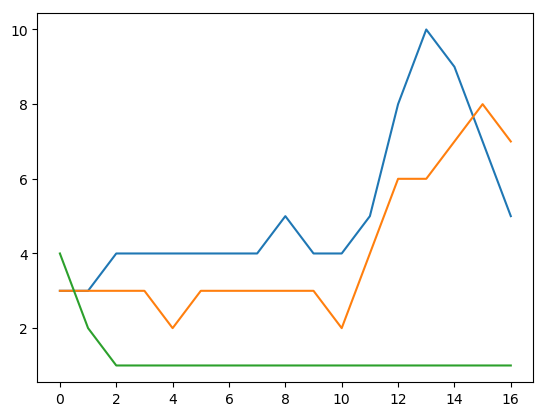

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x129928e90>

In [37]:
plot(out["q_nnz"]); plot(out["y_nnz"]); plot(out["linesearch"])

In [ ]:
srand(1)
x = normtmixdatasim(round(Int,2e5));
sd = autoselectmixsd(x,nv = 100);
L  = normlikmatrix(x,sd = sd);
out = QPsubprob(L, method = "activeset");
plot(out["q_nnz"]); plot(out["y_nnz"]); plot(out["linesearch"])

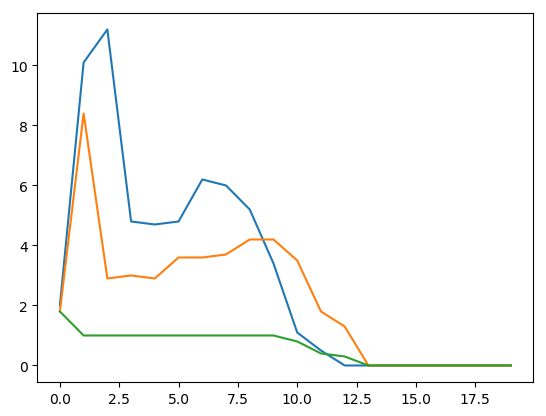

3-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x129aeab50>
 PyObject <matplotlib.lines.Line2D object at 0x129aeac10>
 PyObject <matplotlib.lines.Line2D object at 0x129aeacd0>

In [22]:
t = zeros(20,3)
for i = 1:10
    srand(i)
    x = normtmixdatasim(round(Int,2e5));
    sd = autoselectmixsd(x,nv = 100);
    L  = normlikmatrix(x,sd = sd);
    out = QPsubprob(L, method = "activeset");
    temp = 1:length(out["q_nnz"]);
    t[temp ,1] += out["q_nnz"]; t[temp ,2] += out["y_nnz"]; t[temp ,3] += out["linesearch"];
end
plot(t[1:13,:]/10)

In [36]:
plot(out)

LoadError: [91mPyError (ccall(@pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, arg, C_NULL)) <type 'exceptions.TypeError'>
TypeError('float() argument must be a string or a number',)
  File "/Users/youngseok/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/pyplot.py", line 3358, in plot
    ret = ax.plot(*args, **kwargs)
  File "/Users/youngseok/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/__init__.py", line 1855, in inner
    return func(ax, *args, **kwargs)
  File "/Users/youngseok/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/axes/_axes.py", line 1528, in plot
    self.add_line(line)
  File "/Users/youngseok/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/axes/_base.py", line 1932, in add_line
    self._update_line_limits(line)
  File "/Users/youngseok/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/axes/_base.py", line 1954, in _update_line_limits
    path = line.get_path()
  File "/Users/youngseok/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/lines.py", line 951, in get_path
    self.recache()
  File "/Users/youngseok/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/lines.py", line 657, in recache
    y = _to_unmasked_float_array(yconv).ravel()
  File "/Users/youngseok/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 2050, in _to_unmasked_float_array
    return np.asarray(x, float)
  File "/Users/youngseok/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/numpy/core/numeric.py", line 492, in asarray
    return array(a, dtype, copy=False, order=order)
[39m

In [35]:
te = t[1:14,:];
@rput te
R"write.csv(te,'fig4_dat1.csv')"

RCall.RObject{RCall.NilSxp}
NULL


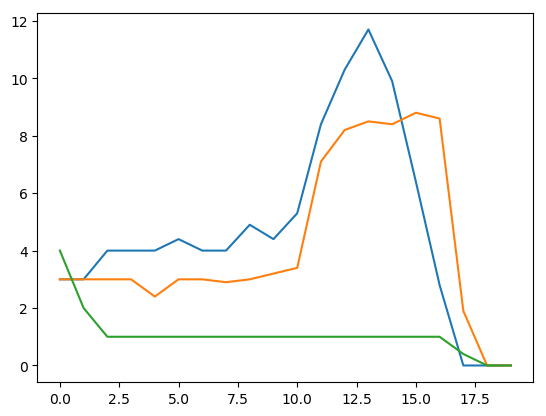

3-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12931cb90>
 PyObject <matplotlib.lines.Line2D object at 0x12931cc50>
 PyObject <matplotlib.lines.Line2D object at 0x12931cd10>

In [30]:
t1 = zeros(20,3)
for i = 1:10
    srand(i)
    x = normdatasim(round(Int,5e4));
    sd = autoselectmixsd(x,nv = 100);
    L  = normlikmatrix(x,sd = sd);
    out = QPsubprob(L, method = "activeset");
    temp = 1:length(out["q_nnz"]);
    t1[temp ,1] += out["q_nnz"]; t1[temp ,2] += out["y_nnz"]; t1[temp ,3] += out["linesearch"];
end
plot(t1/10)